# Predict

> A notebook to predict the test_set

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

pred_path = path.parent / "predictions"
pred_path.mkdir(parents=True, exist_ok=True)

In [ ]:
print_competition_data(models_dir)

models/ResNet18-Unet-kaggle.pth
models/ResNet34-Unet-256-stage2.pth
models/ResNet34-Unet-256-stage1.pth
models/.ipynb_checkpoints
models/ResNet18-Classifier-kaggle.pth
models/ResNet34-Unet-256-stage3.pth
models/ResNet34-Unet-128-stage2.5.pth


In [ ]:
arch = resnet34
bs = 4 
dls = get_segmentation_dls(bs, (256, 1600))
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage3")

In [ ]:
segmentation_learner.validate()

(#3) [0.04447552189230919,0.7086918457073045,0.9205705523490906]

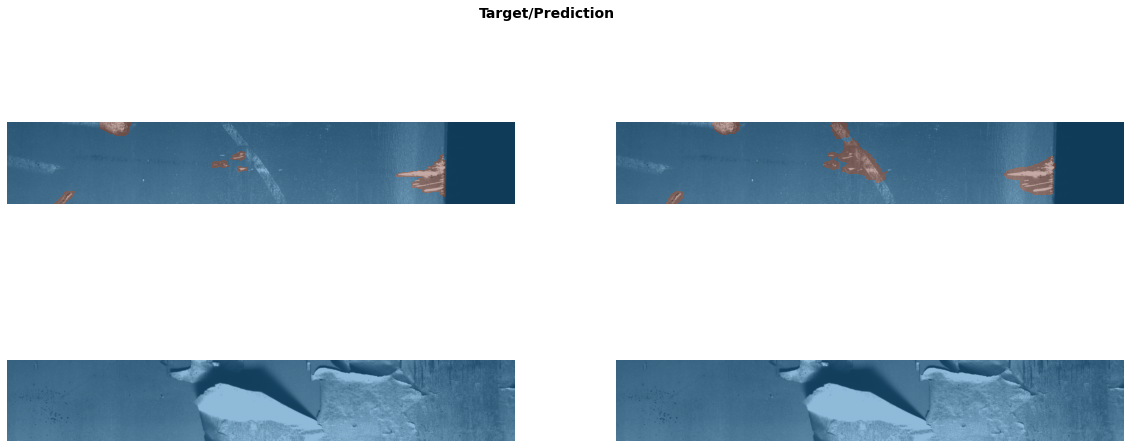

In [ ]:
segmentation_learner.show_results(figsize=(20,8))

In [ ]:
img_paths = get_image_files(test_path)
size_fold = 100
elems = len(img_paths)
folds = (elems // size_fold) + 1
threshold = 0.5
min_size = 3500
df_preds = []

In [ ]:
def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
for fold in tqdm(range(folds)):
    predictions = []
    
    start, end = fold*size_fold, (fold+1)*size_fold
    print(f"From {start} to {end}")
    selected_imgs = img_paths[start:end]
    # get predictions
    test_dl = segmentation_learner.dls.test_dl(test_items=selected_imgs)
    pred_probs, _, pred_masks = segmentation_learner.get_preds(dl=test_dl, with_decoded=True)
    # get img names
    img_names = L(test_dl.items).map(lambda x: x.name)
    # calc the RLEs
    for num_pred, t_pred in enumerate(pred_probs): # img in bs
        np_pred = t_pred.numpy()
        # iterate through class_id without class_id 0
        for class_id, prob in enumerate(np_pred[1:]): 
            pred, num = post_process(prob, threshold, min_size)
            rle = mask2rle(pred)
            name = img_names[num_pred] + f"_{class_id+1}"
            predictions.append([name, rle])
            
    tmp_df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
    df_preds.append(tmp_df)

    torch.cuda.empty_cache()
    del predictions

  0%|          | 0/56 [00:00<?, ?it/s]

From 0 to 100


  2%|▏         | 1/56 [00:36<33:48, 36.89s/it]

From 100 to 200


  4%|▎         | 2/56 [01:08<31:49, 35.36s/it]

From 200 to 300


  5%|▌         | 3/56 [01:39<30:07, 34.10s/it]

From 300 to 400


  7%|▋         | 4/56 [02:12<29:04, 33.56s/it]

From 400 to 500


  9%|▉         | 5/56 [02:43<27:58, 32.91s/it]

From 500 to 600


 11%|█         | 6/56 [03:15<27:09, 32.60s/it]

From 600 to 700


 12%|█▎        | 7/56 [03:47<26:29, 32.43s/it]

From 700 to 800


 14%|█▍        | 8/56 [04:19<25:50, 32.31s/it]

From 800 to 900


 16%|█▌        | 9/56 [04:51<25:11, 32.17s/it]

From 900 to 1000


 18%|█▊        | 10/56 [05:23<24:34, 32.06s/it]

From 1000 to 1100


 20%|█▉        | 11/56 [05:55<24:02, 32.06s/it]

From 1100 to 1200


 21%|██▏       | 12/56 [06:27<23:31, 32.08s/it]

From 1200 to 1300


 23%|██▎       | 13/56 [06:59<22:58, 32.05s/it]

From 1300 to 1400


 25%|██▌       | 14/56 [07:30<22:18, 31.88s/it]

From 1400 to 1500


 27%|██▋       | 15/56 [08:02<21:42, 31.76s/it]

From 1500 to 1600


 29%|██▊       | 16/56 [08:34<21:12, 31.81s/it]

From 1600 to 1700


 30%|███       | 17/56 [09:06<20:42, 31.86s/it]

From 1700 to 1800


 32%|███▏      | 18/56 [09:38<20:11, 31.89s/it]

From 1800 to 1900


 34%|███▍      | 19/56 [10:09<19:39, 31.89s/it]

From 1900 to 2000


 36%|███▌      | 20/56 [10:42<19:10, 31.95s/it]

From 2000 to 2100


 38%|███▊      | 21/56 [11:13<18:37, 31.93s/it]

From 2100 to 2200


 39%|███▉      | 22/56 [11:45<18:06, 31.96s/it]

From 2200 to 2300


 41%|████      | 23/56 [12:17<17:33, 31.94s/it]

From 2300 to 2400


 43%|████▎     | 24/56 [12:49<17:02, 31.95s/it]

From 2400 to 2500


 45%|████▍     | 25/56 [13:21<16:28, 31.87s/it]

From 2500 to 2600


 46%|████▋     | 26/56 [13:53<15:53, 31.77s/it]

From 2600 to 2700


 48%|████▊     | 27/56 [14:24<15:18, 31.66s/it]

From 2700 to 2800


 50%|█████     | 28/56 [14:56<14:47, 31.69s/it]

From 2800 to 2900


 52%|█████▏    | 29/56 [15:28<14:16, 31.73s/it]

From 2900 to 3000


 54%|█████▎    | 30/56 [16:00<13:46, 31.80s/it]

From 3000 to 3100


 55%|█████▌    | 31/56 [16:32<13:20, 32.00s/it]

From 3100 to 3200


 57%|█████▋    | 32/56 [17:03<12:42, 31.79s/it]

From 3200 to 3300


 59%|█████▉    | 33/56 [17:35<12:13, 31.89s/it]

From 3300 to 3400


 61%|██████    | 34/56 [18:07<11:39, 31.80s/it]

From 3400 to 3500


 62%|██████▎   | 35/56 [18:39<11:08, 31.83s/it]

From 3500 to 3600


 64%|██████▍   | 36/56 [19:10<10:35, 31.77s/it]

From 3600 to 3700


 66%|██████▌   | 37/56 [19:42<10:04, 31.79s/it]

From 3700 to 3800


 68%|██████▊   | 38/56 [20:14<09:32, 31.82s/it]

From 3800 to 3900


 70%|██████▉   | 39/56 [20:46<08:59, 31.76s/it]

From 3900 to 4000


 71%|███████▏  | 40/56 [21:18<08:28, 31.77s/it]

From 4000 to 4100


 73%|███████▎  | 41/56 [21:49<07:55, 31.69s/it]

From 4100 to 4200


 75%|███████▌  | 42/56 [22:21<07:24, 31.78s/it]

From 4200 to 4300


 77%|███████▋  | 43/56 [22:54<06:55, 31.97s/it]

From 4300 to 4400


 79%|███████▊  | 44/56 [23:25<06:23, 31.92s/it]

From 4400 to 4500


 80%|████████  | 45/56 [23:57<05:48, 31.72s/it]

From 4500 to 4600


 82%|████████▏ | 46/56 [24:28<05:17, 31.76s/it]

From 4600 to 4700


 84%|████████▍ | 47/56 [25:00<04:45, 31.73s/it]

From 4700 to 4800


 86%|████████▌ | 48/56 [25:31<04:12, 31.55s/it]

From 4800 to 4900


 88%|████████▊ | 49/56 [26:03<03:41, 31.66s/it]

From 4900 to 5000


 89%|████████▉ | 50/56 [26:35<03:10, 31.83s/it]

From 5000 to 5100


 91%|█████████ | 51/56 [27:08<02:39, 31.92s/it]

From 5100 to 5200


 93%|█████████▎| 52/56 [27:40<02:08, 32.04s/it]

From 5200 to 5300


 95%|█████████▍| 53/56 [28:12<01:35, 31.97s/it]

From 5300 to 5400


 96%|█████████▋| 54/56 [28:44<01:04, 32.04s/it]

From 5400 to 5500


 98%|█████████▊| 55/56 [29:16<00:32, 32.03s/it]

From 5500 to 5600


100%|██████████| 56/56 [29:22<00:00, 31.47s/it]


Saving predictions to `submission.csv`.

In [ ]:
df = pd.concat(df_preds, axis=0, ignore_index=True)
df.fillna("", inplace=True)
df.to_csv(path/"resnet34_fastai_sub.csv", index=False)